In [82]:
#importing librabries

import pandas as pd   
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [83]:
data = pd.read_csv('indian_liver_patient.csv')

## Data prep
========================================================================================================================

In [84]:
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [85]:
data.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [86]:
data.shape

(583, 11)

In [87]:
data.dropna(inplace=True)

#### Here we one-hot encode the gender column using get_dummies(), dropping the first column.


In [88]:
gender = pd.get_dummies(data['Gender'],drop_first=True)

In [89]:
data.drop(columns='Gender', inplace=True)

In [90]:
data = pd.concat([data,gender], axis=1)

In [91]:
data.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,Male
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1,0
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,1
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,1
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,1
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,1


In [92]:
data = data.astype(float)

 ##### We rename the columns using the common medical abbreviations to make them easier to use.
 

In [93]:
data.columns=['Age', 'Total_BUN', 'Direct_BUN',
              'ALP', 'ALAT', 'AST', 'Total_Protiens',
              'ALB', 'ALB:BLOB','Dataset', 'Female']

In [94]:
data.head()

,Age,Total_BUN,Direct_BUN,ALP,ALAT,AST,Total_Protiens,ALB,ALB:BLOB,Dataset,Female
0,65.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1.0,0.0
1,62.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1.0,1.0
2,62.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1.0,1.0
3,58.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1.0,1.0
4,72.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1.0,1.0


####  The classes are unbalanced(we will deal with this later using upsampling or by choosing a model that does well with inbalance). The README said the dataset had an unbalanced class distribution of 416 patients with liver disease and 167 patients without liver disease.
I'll use this information to make a succinct y column out of the data['Dataset'] column.


In [95]:
data['Dataset'].value_counts() 

1.0    414
2.0    165
Name: Dataset, dtype: int64

 #### The counts are 2 patients less on each from the dropna called at the beginning of the notebook. Patients with the value 1 have liver disease, those with the value 2 do not. 
 Below I reassigned the patients without liver disease(2.0) to 0  and renamed the column to 'Diagnosis' because I like my columns simple to interpret.

In [96]:
data.Dataset = data.Dataset.astype(int)
data.rename(columns={'Dataset':'Diagnosis'}, inplace=True)

In [97]:
data.Diagnosis.replace({2:0}, inplace=True)

In [98]:
data.head(10)

,Age,Total_BUN,Direct_BUN,ALP,ALAT,AST,Total_Protiens,ALB,ALB:BLOB,Diagnosis,Female
0,65.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1,0.0
1,62.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1,1.0
2,62.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1,1.0
3,58.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1,1.0
4,72.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1,1.0
5,46.0,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.30,1,1.0
6,26.0,0.9,0.2,154.0,16.0,12.0,7.0,3.5,1.00,1,0.0
7,29.0,0.9,0.3,202.0,14.0,11.0,6.7,3.6,1.10,1,0.0
8,17.0,0.9,0.3,202.0,22.0,19.0,7.4,4.1,1.20,0,1.0
9,55.0,0.7,0.2,290.0,53.0,58.0,6.8,3.4,1.00,1,1.0


### We will upsample the minority class to prevent the inbalance from affecting our model*


In [99]:
#seperating the dataset by the y column

positive = data[data['Diagnosis'] == 1]  
negative = data[data['Diagnosis'] == 0]

# upsampling the negative class

negative_up = resample(negative,
                      replace=True,
                      n_samples=414,
                      random_state=42)

In [100]:
# Creating the new dataframe with balanced classes

data = pd.concat([positive, negative_up], axis=0)

#confirming our classes are balanced so we can move onto modeling

data.Female.value_counts()

1.0    623
0.0    205
Name: Female, dtype: int64

## Modeling

### Below we will create a model for our baseline then use gridsearch to choose a model and parameters

=====================================================================================================================
####  Random Forest as the base accuracy model



In [101]:
#creating my X and y

X = data.drop(columns=['Diagnosis'])
y = data.Diagnosis

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, # creating a train and test set 
                                                    random_state=42) # Random state for reproducability

# scaling for the models that need it
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

ss= StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [103]:
#instaniating our model

rfc = RandomForestClassifier()
rfc.fit(X_train_sc, y_train)

/home/i/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [104]:
preds = rfc.predict(X_test_sc) #getting predictions for x test to see their accuracy.

### We got a base accuracy of 80% using a Random Forest on  the balanced Dataset

In [105]:
print(accuracy_score(y_test, preds))

0.8164251207729468


#### Next we will try a basic logistic regression and a support vector machine

In [106]:
log = LogisticRegression()
log.fit(X_train_sc, y_train)
log.score(X_test_sc, y_test)

/home/i/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6859903381642513

In [107]:
svc = SVC(kernel='rbf', probability=True )
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

/home/i/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9178743961352657

### The SVM did a whopping 92% out of the box, now lets see if we can improve on that!

## Model  improvement 
==========================

Here we will attempt to improve our score through tuning our models hyperparameters using gridsearch

In [108]:
# creating our gridsearch params
svg = SVC()

params = {
    'C':[1.0, 2, .65, .8],
    'kernel':['rbf','linear', 'poly'],
    'gamma':[.1,.4,.7,1]
    
    }

# instaniating our gridsearch

gs = GridSearchCV(svg, params, cv=3)


In [109]:
gs.fit(X_train_ss, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1.0, 2, 0.65, 0.8], 'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.1, 0.4, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [110]:
gs.best_params_

{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

#### ***The grid search on the SVC didn't increate the accuracy much so we will use the base SVC from this point.***

## Visualizations and Insights

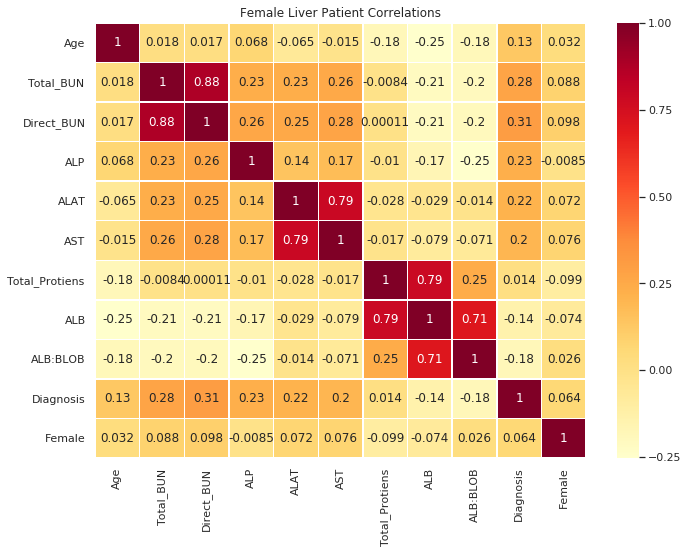

In [143]:
sns.set(rc={'figure.figsize':(11,8)})
ax = plt.axes()
ax.set_title('Female Liver Patient Correlations')
sns.heatmap(data.corr(),
           annot=True,
            linewidths=.5,
            cmap='YlOrRd'
            )


In [48]:
# Checking the correlation between liver disease diagnosis and the levels of chemicals present in the patients  

X.corrwith(y)

Age               0.131234
Total_BUN         0.276926
Direct_BUN        0.309723
ALP               0.230289
ALAT              0.216685
AST               0.197883
Total_Protiens    0.014424
ALB              -0.139345
ALB:BLOB         -0.179911
Female            0.064359
dtype: float64

##### Lets see if there is any substancial difference in the correlation between the chemical intake and diagnosis between men and women

In [118]:
# Creating seperate dataframes for the male and female patients

female = data[data.Female == 1]
male = data[data.Female == 0]

In [51]:
# Creating the target columns for the male and female patients

female_diag = female.Diagnosis
male_diag = male.Diagnosis


In [52]:
# Creating the feature dataset for the male and female patients

female_data = female.drop(columns=['Diagnosis'])
male_data = male.drop(columns=['Diagnosis'])

In [53]:
# Female diagnosis correlation
female_data.corrwith(female_diag)

Age               0.165532
Total_BUN         0.276961
Direct_BUN        0.314510
ALP               0.205862
ALAT              0.218092
AST               0.194379
Total_Protiens    0.007514
ALB              -0.166271
ALB:BLOB         -0.200080
Female                 NaN
dtype: float64

In [54]:
# Male diagnosis correlation
male_data.corrwith(male_diag)

Age               0.013257
Total_BUN         0.266861
Direct_BUN        0.276855
ALP               0.298058
ALAT              0.235020
AST               0.268403
Total_Protiens    0.059213
ALB              -0.045556
ALB:BLOB         -0.120920
Female                 NaN
dtype: float64

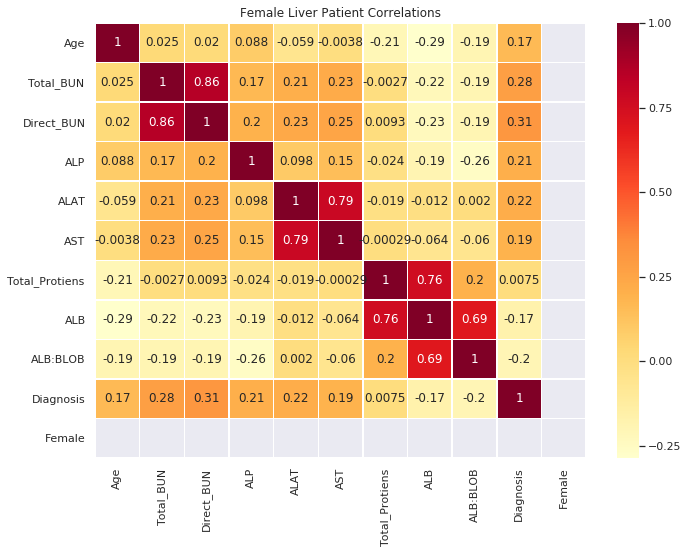

In [139]:
sns.set(rc={'figure.figsize':(11,8)})
ax = plt.axes()
ax.set_title('Female Liver Patient Correlations')
sns.heatmap(female.corr(),
           annot=True,
            linewidths=.5,
            cmap='YlOrRd'
            )


##### Lets see how the SVC does on the female patients

In [133]:
base_y_female = female.Diagnosis
base_X_female = female.drop(columns='Diagnosis')

In [113]:
X_train, X_test, y_train, y_test = train_test_split(base_X_female, base_y_female, 
                                                    random_state=42)

In [144]:
fsvc = SVC()
fsvc.fit(X_train, y_train)
fsvc.score(X_test, y_test)

/home/i/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9358974358974359

#### 93.5% classifcation accuracy of female patients

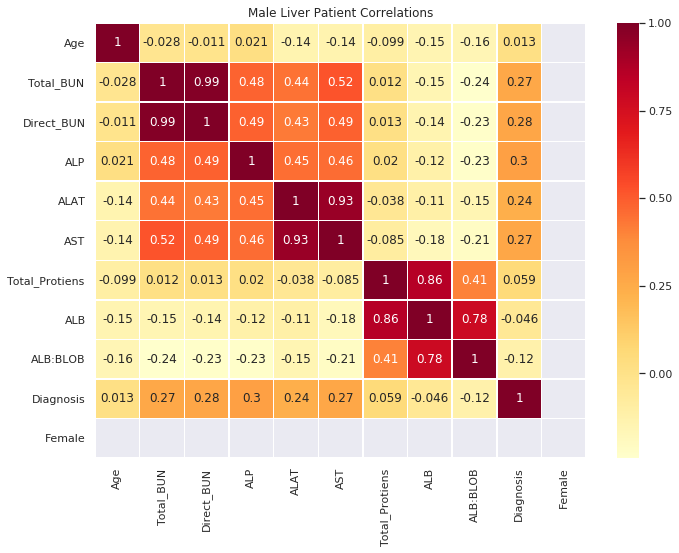

In [142]:
ax = plt.axes()
ax.set_title('Male Liver Patient Correlations')
sns.heatmap(male.corr(),
           annot=True,
            linewidths=.5,
            cmap='YlOrRd'
            )


##### The males have a few correlations that are a bit divergent from those of the women. Lets look into them!

In [61]:
base_y_male = male.Diagnosis
base_X_male = male.drop(columns='Diagnosis')

In [62]:
X_train, X_test, y_train, y_test = train_test_split(base_X_male, base_y_male, 
                                                    random_state=42) 


In [63]:
msvc = SVC()
msvc.fit(X_train, y_train)
msvc.score(X_test, y_test)

/home/i/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9423076923076923

#### 94.2% classification accuracy of male patients

### Though accuracy of the SVC is very close between the male and female patients, the male patients have a few  correlations that were not as strong in females.
- Male Total Protiens levels had a correlation with being positively diagnosed with liver disease almost  8X higher than that of females
    female- 0.007514 | male- 0.059213
- Male Total BUN and Direct BUN levels where about twice as correlated with levels ALP, ALAT, and AST as that off females.
- Males ABLOB levels and Total protiens levels correlation is twice that of females.
- Total BUN, Direct BUN, ALP, ALAT, and AST had the highest correlations with a positive liver disease diagnosis in boths sexes with correlations ranging from .2 to .,3